# What Does an Ideal Data Scientist's Profile Look Like?
## - Findings from Analyzing 1000 Indeed Job Postings


If you are a Data Science job seeker, you must be wondering all the time what skills to put on your resume to get calls; if you are looking to get into the field, you may have scratched your head many times wanting to know which technlogies to learn to be an attractive candidate. 

Read on, I have the answer for you. 

To answer this question quantitatively,I scraped 1000 job postings from Indeed for roles including Data Scientist, Machine Learning Engineer and Data Engineer, and made word cloud plots. These word clouds clearly identify the most frequently required qualifications in job postings, thus depict the ideal profiles for various data science roles. The top keywords in the plots can then be used to increase our resume's relevance and inform our learning decisions. So let's take a look!

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scrape_data import *
from process_text import *
from helper import *

### Data Scientist is More about Machine Learning than Business or Analytics

Data Scientist has been regarded as the all-around profession that requires statitics, analytics, machine learning and business knowledge. It seems that's still the case, or at least, there are still various needs in a Data Scientist. However, it definitely seems now Data Scientists are more about machine learning than anything else. Other top requirements include: business, management, communication, research, development, analytics, product, technical, statistics, algorithm, models, customer/client and computer science.

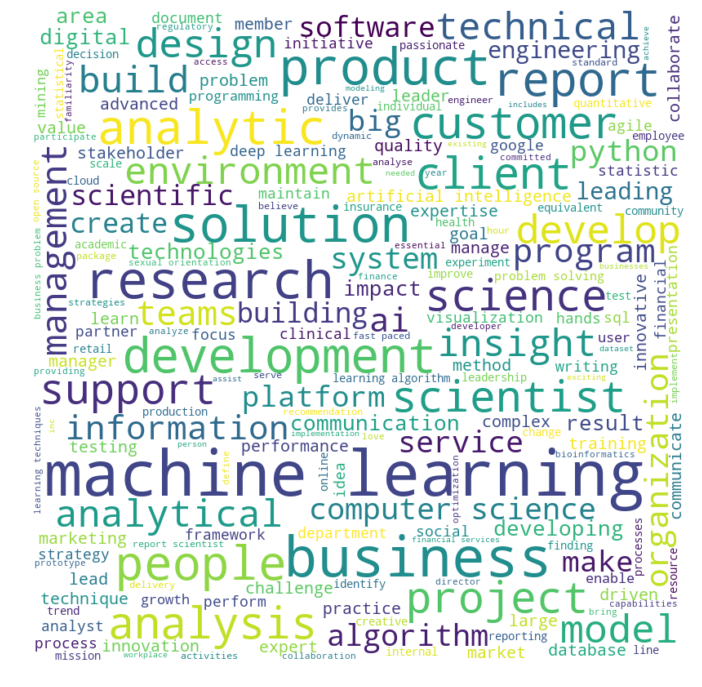

In [2]:
plot_profile('data scientist', max_words=200, first_n_postings=120)

### Machine Learning Engineers are about Research, System Design and Building

Compared with general Data Scientists, Machine Learning Engineers definitely seem to have a more focused portfolio which includes research, design and engineering. Clearly solution, product, software and system are the dominating theme. Accompanying those, there are research, algorithm, ai, deep learning and computer vision. Interestingly, terms such as business, management, customer and communication also seem to be important. This can be further investigated in a further iteration of this project. On the other hand, piple and platform also stand out, confirming common understanding of Machine Learning Engineer's responsibility in building data pipelines to deploy ML systems.

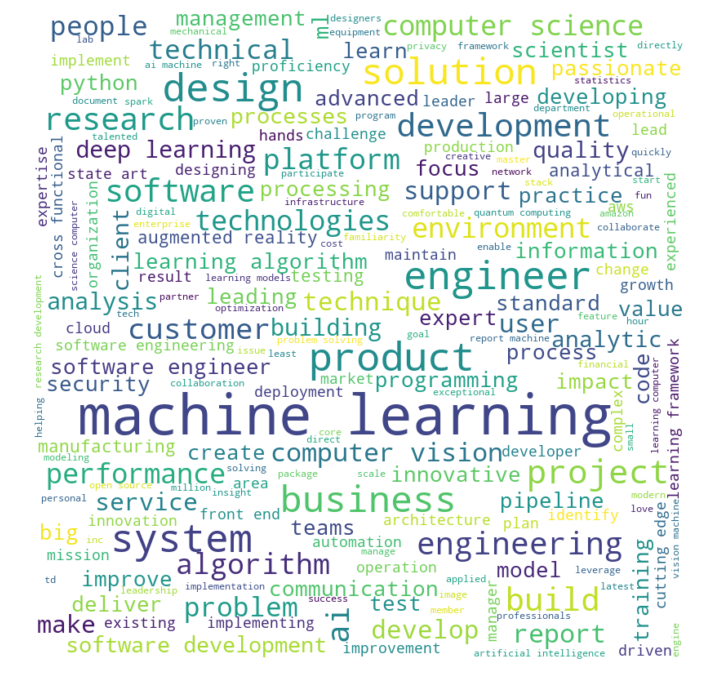

In [3]:
plot_profile('machine learning engineer', max_words=200, first_n_postings=120)

### Data Engineer is the Real Specialist

Data Engineers have an even more focused portfolio than Machine Learning Engineers. Clearly, the focus is to support product, system and solution through designing and developing pipelines. Top requirements include technical skills, database, built, testing, environment, quality. Machine learning is also important, possibly because the pipelines are mainly built to support machine learning application data needs.

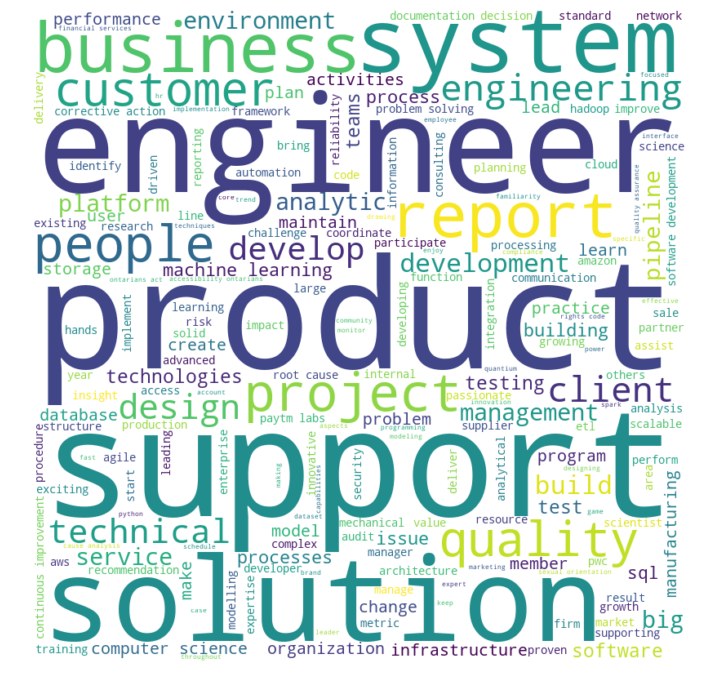

In [4]:
plot_profile('data engineer', max_words=200, first_n_postings=120)

Let's now examine the various skills required for different roles.

In [5]:
df = pd.read_csv('skill_frequencies.csv')

### SQL is the Absolute Must if you want to be a Data Engineer
Data Engineers deal with database all the time and SQL is the database language, so no wonder SQL is the top language. Python is important, but still loses to Scala and Java since these languages help Data Engineers handle big data. Top languages for Data Engineers are: _SQL, Scala, Java, Python and Lua_.


### No more debate between Python and R since Python is the Dominating Leader
There once was a debate of whether Python or R is the language of choice in data science. Clearly the demand in market is telling us that Python now is the leader now. It's also worth noting that R got even fewer mentions than SAS. Therefore, if you are considering getting into data science, consider focus your learning efforts on Python. SQL as the language of database (and maybe data as well), comes as the second most important language for a Data Scientist. Becasue of broad nature of the Data Scientist profession, other languages also play import roles. In summary, the top languages for a Data Scientist are: _Python, SQL, Scala, Lua, Java, SAS, R, C++ and Matlab_. 


### Languages Required for Machine Learning Engineers are More Diverse
Python as the defacto language of machine learning comes unsurprisingly as the top language for Machine Learning Engineers. Because of the need to implement algorithms from scratch and deploy ML models in a big data environment, relevant languages such as C++ and Scala are also important. Overall, it seems the need of languages are more spread out compared with the other two roles. Top languages for Machine Learning Engineers are: _Python, Scala, Java, C++, Lua, SQL, Javascript, Matlab, CSS and C#_.



### Scala is Emerging as the second most import Language in Data Science
When we examine across different roles, interestingly, Scala comes up as either second or third in the skills. So we can say the top three languages in data science are _Python, SQL and Scala_. If you are thinking of learning a new language, consider Scala!

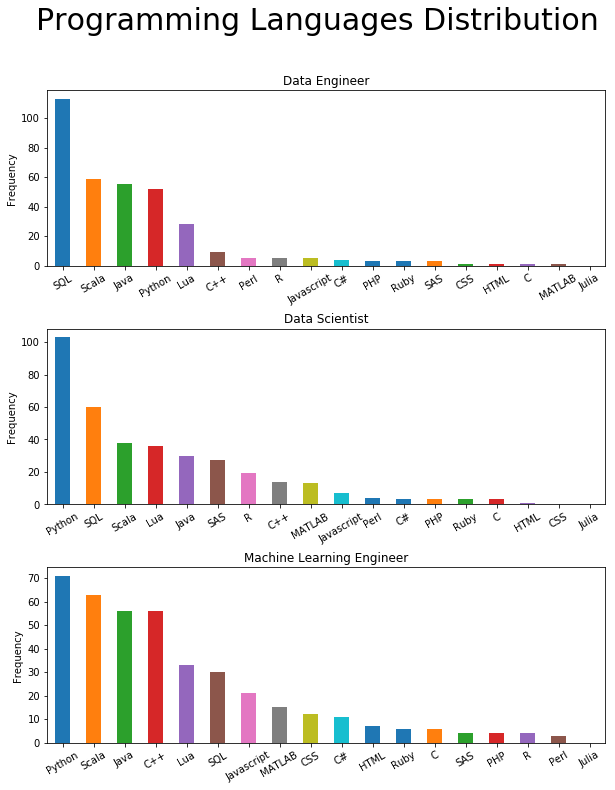

In [6]:
plot_skill(df, 'programming languages', save_figure=True)

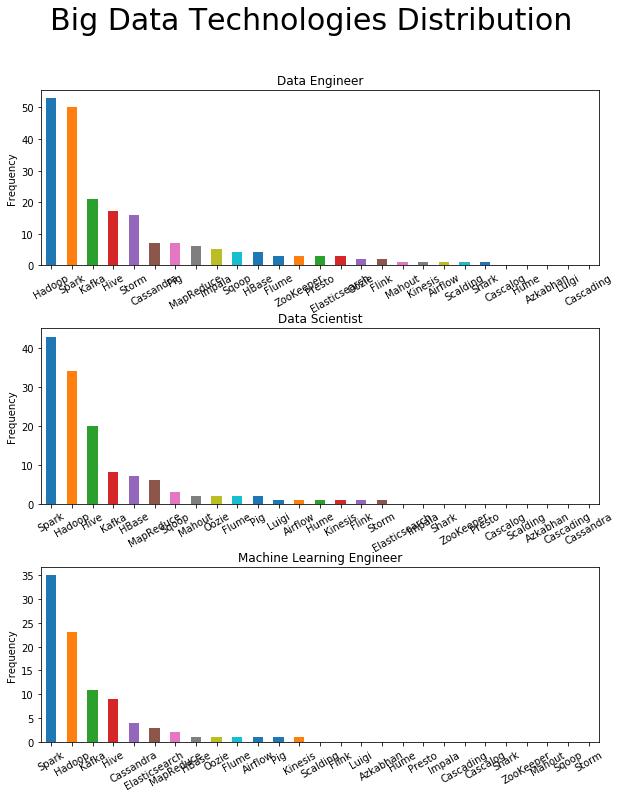

In [7]:
plot_skill(df, 'big data technologies', save_figure=True)

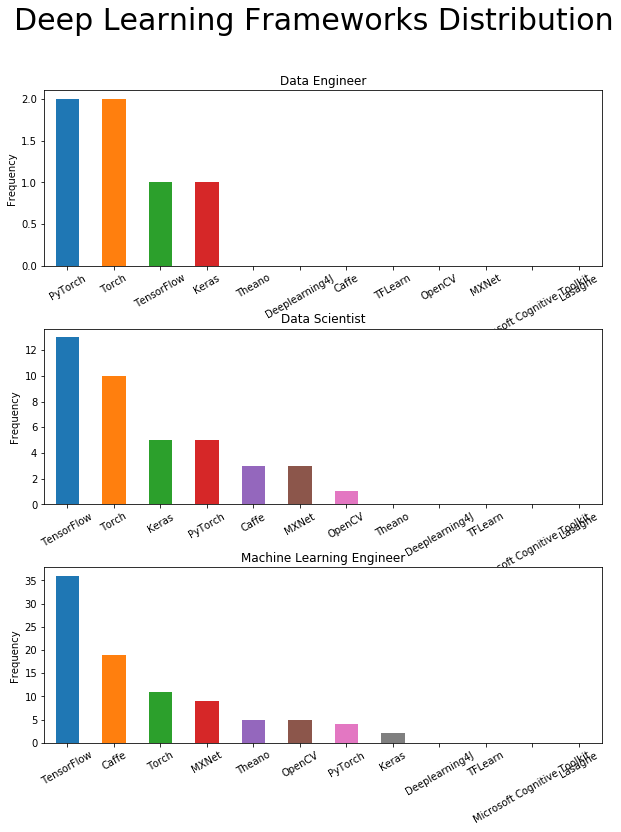

In [8]:
plot_skill(df, 'deep learning frameworks', save_figure=True)

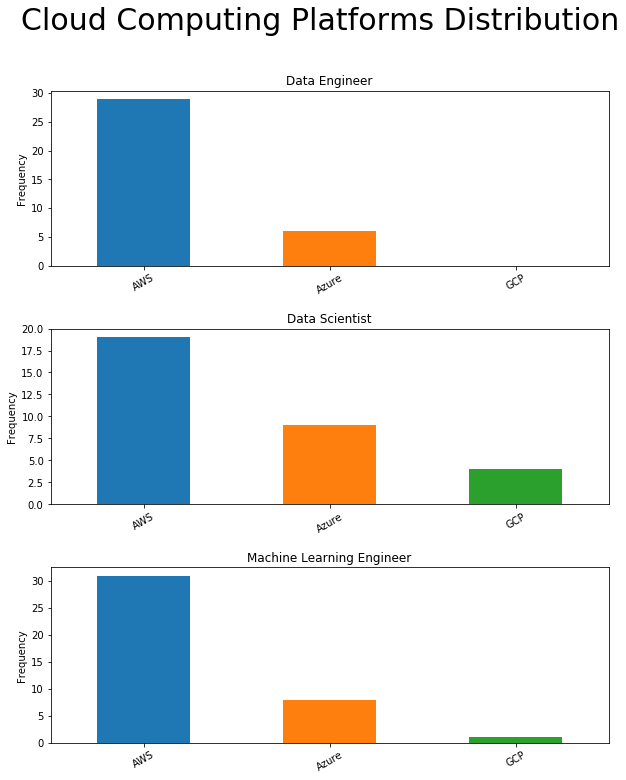

In [9]:
plot_skill(df, 'cloud computing platforms', save_figure=True)

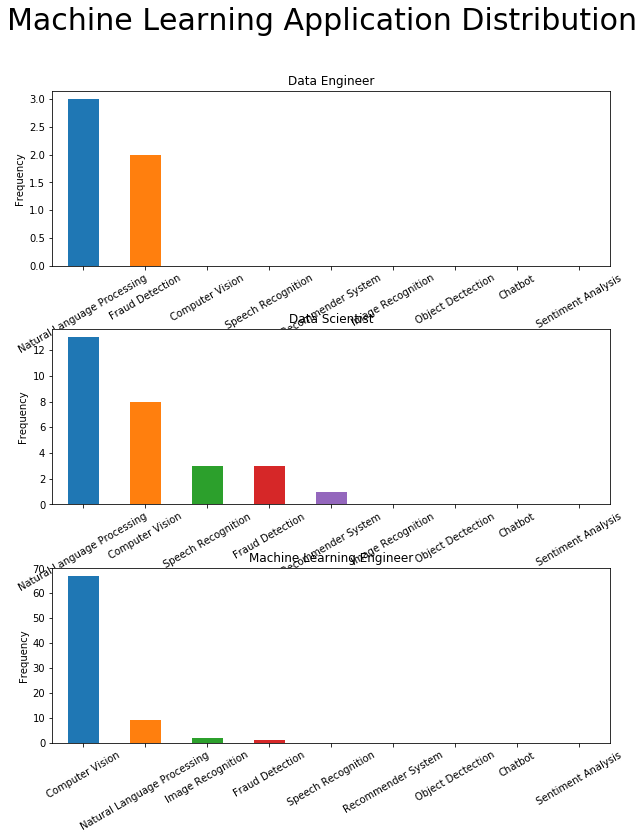

In [10]:
plot_skill(df, 'machine learning application', save_figure=True)

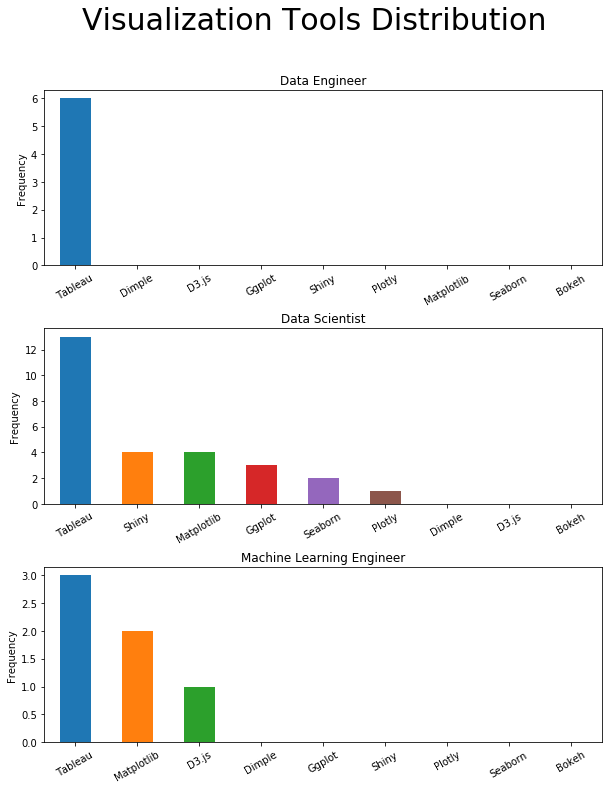

In [11]:
plot_skill(df, 'visualization tools', save_figure=True)

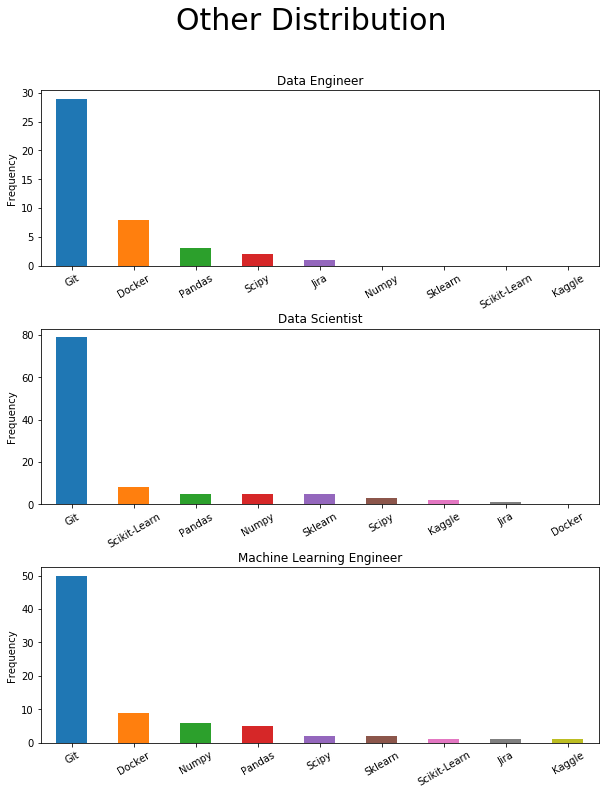

In [12]:
plot_skill(df, 'other', save_figure=True)

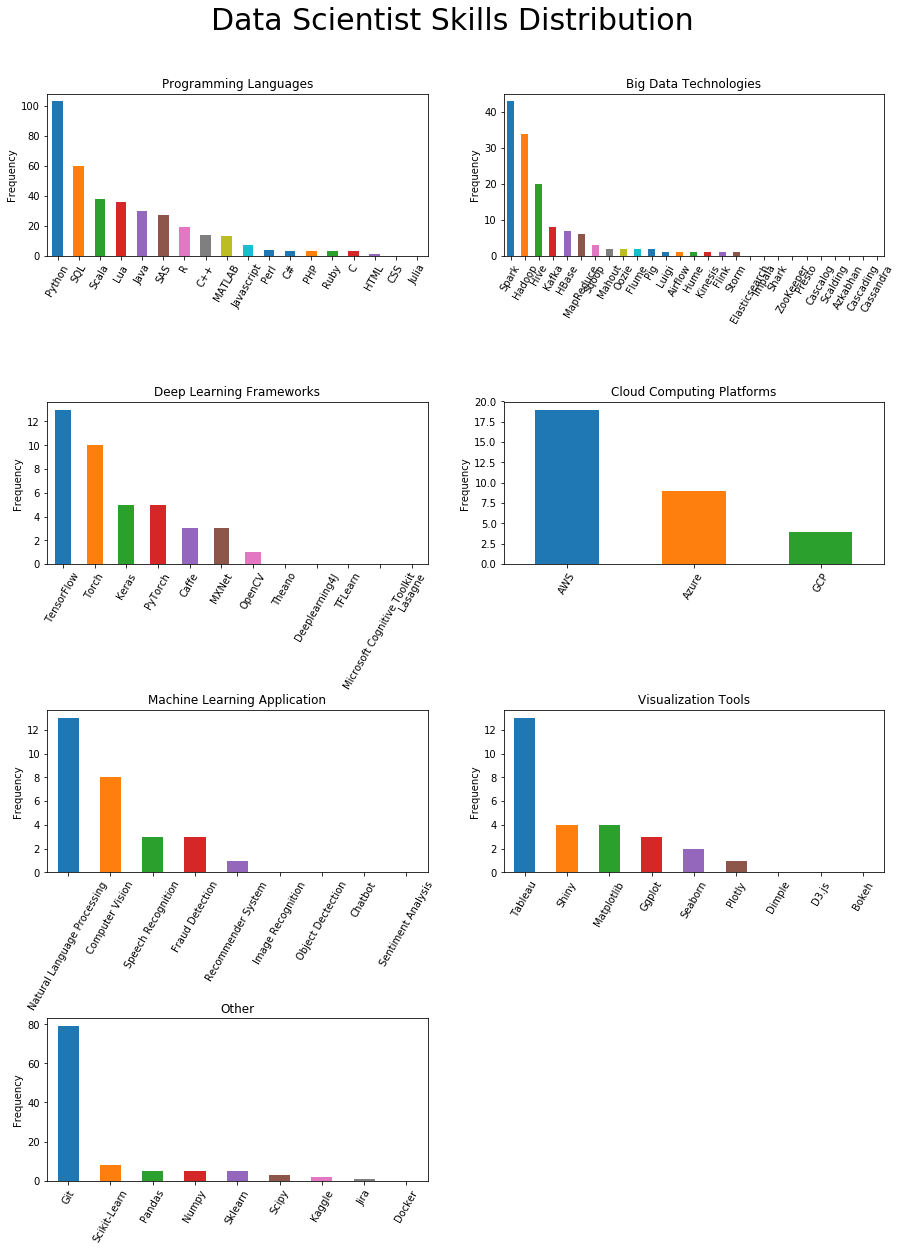

In [13]:
plot_title(df, 'data scientist', save_figure=True)

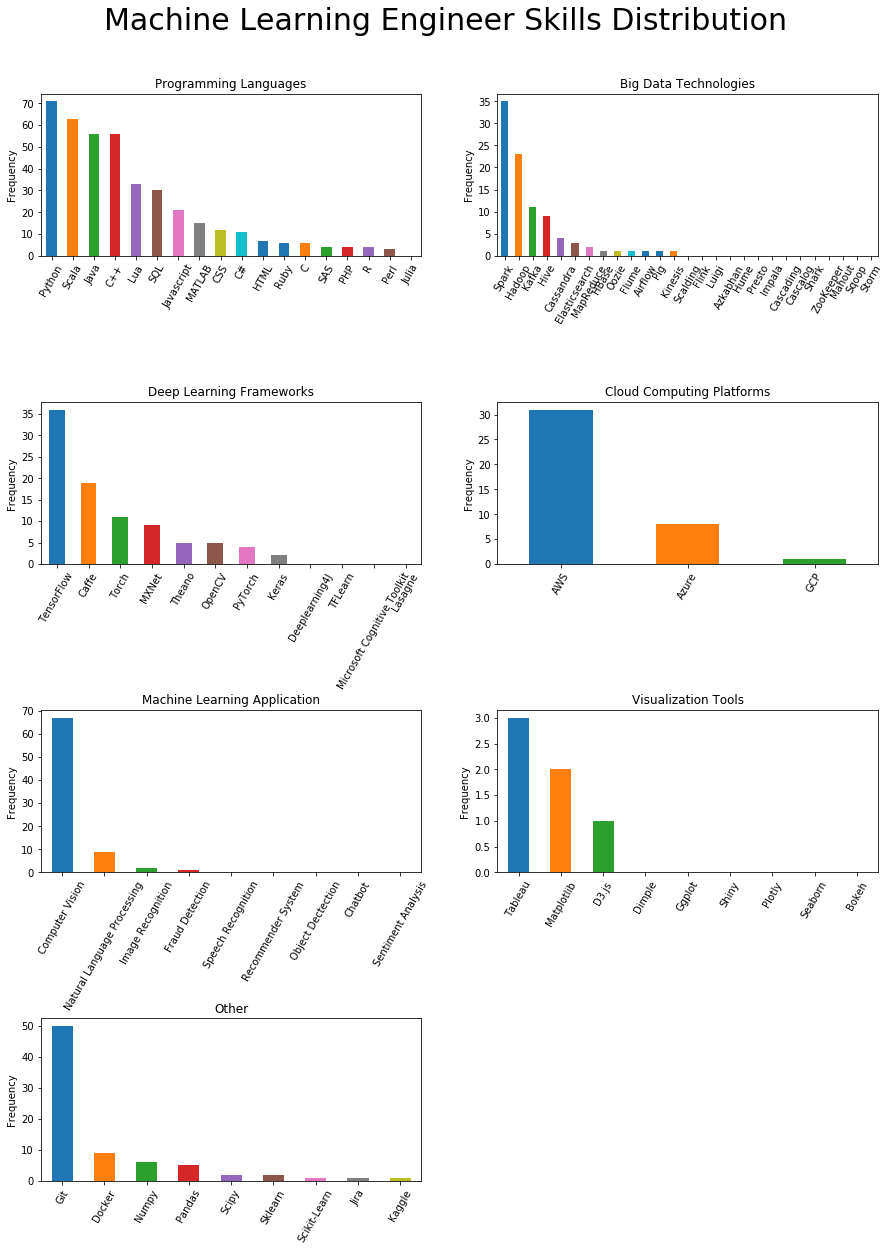

In [14]:
plot_title(df, 'machine learning engineer', save_figure=True)

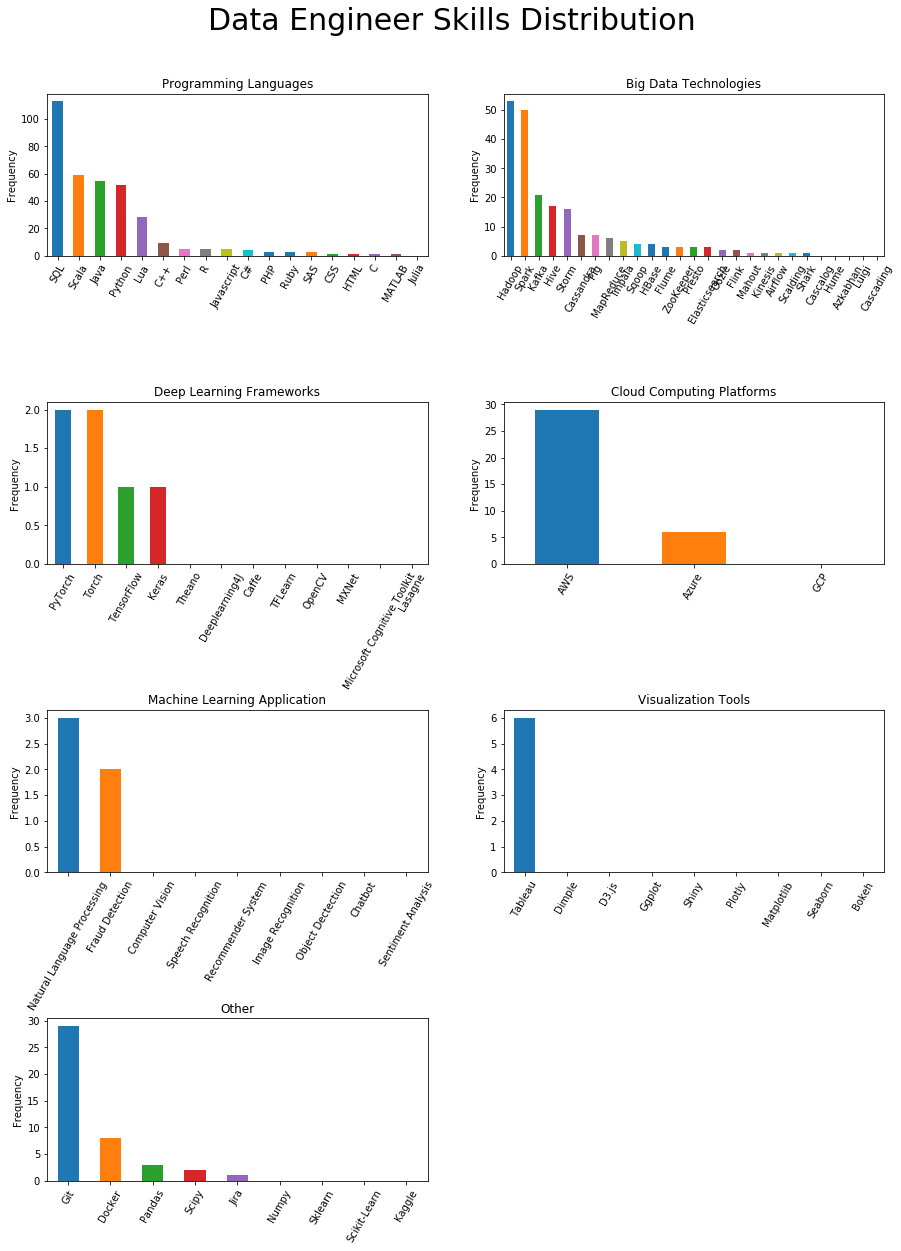

In [15]:
plot_title(df, 'data engineer', save_figure=True)

## Todo's
- readme, dependencies
- refactor notebook code
- confirm r's ranking
- get more data on indeed usa
- show context for specific words in word clouds
- docstring and comments
- OOP
- single responsiblity principle for functions
- assumptions and limitations (sample representative...)